In [2]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Serif"
import pyipmeta as ipm
import requests
import wget
import shutil
import gzip
import json

from sklearn.linear_model import LinearRegression
import numpy as np

import geoplot.crs as gcrs
import geoplot
import os
from datetime import datetime
import socket 
import sys
import netaddr

In [3]:


import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
from dask.distributed import Client, LocalCluster


In [179]:
cluster = LocalCluster(n_workers=8, threads_per_worker=1, dashboard_address=':37940')  # Launches a scheduler and workers locally
client = Client(cluster) 
cluster.dashboard_link

'http://127.0.0.1:37940/status'

In [5]:

meta = ipm.IpMeta(providers=["pfx2as -f " + 'pfx_to_as/routeviews-rv2-20220920-1200.txt'])
rir_df = pd.read_csv('/data1/manasvini/rir.csv')

In [7]:
def get_files_no_pfx(dirname):
    
    files = [os.path.join(dirname, f) for f in os.listdir(dirname) if 'processed' not in f]
    return files

def get_24_from_int(df):
    return df['ipint'].apply(lambda x: ip2int(int2ip24(x)))

def get_24(df):
    return df['ip'].apply(lambda x: '.'.join(x.split('.')[0:3]) + '.0')

def get_int_from_ip(df):
    return df['ip'].apply(lambda x: ip2int(x))

def int2ip24(x):
    ip =  str(netaddr.IPAddress(int(x)))
    return '.'.join(ip.split('.')[0:3]) + '.0'
def ip2int(x):
    return netaddr.IPAddress(x).value

def int2ip(x):
    return str(netaddr.IPAddress(int(x)))

## Sparsity Analysis  
- For the last snapshot, compute the number of blocks vs the number of hosts per block when using the two port startegies:  
    - ANY: select host if it responds to any probe  
    - BEST: select host if it responds to the probe that had the best chance of succeeding

In [8]:
## Load Censys 
censys_survey91_ddfs = []
for i in range(10):
    censys_survey_part_ddf = dd.read_parquet(get_files_no_pfx('/data1/manasvini/censys/proto/best_survey_new_91/part_'+str(i)),  block_size='10MB')
    censys_survey91_ddfs.append(censys_survey_part_ddf)

censys_ddf = dd.concat(censys_survey91_ddfs)
censys_survey91_ddf = censys_ddf.rename(columns={'best_proto_ct':'survey_91'})

In [9]:
censys_survey91_ddf['/24'] = censys_survey91_ddf.map_partitions(get_24_from_int)
#censys_24s = censys_survey91_ddf.groupby('/24')['ipint'].count().compute().reset_index()

In [17]:
## Load ANT
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10withipint/everalive'

files = list(set(get_files_no_pfx(dirname)))

ant_ddf = dd.read_parquet(files, blocksize='200MB')
ant_survey91_ddf = ant_ddf[['ipint', 'survey_91']]

In [ ]:
## Merged ANT and Censys  
## Load Censys 
merged_survey91_ddfs = []
for i in range(10):
    merged_survey_part_ddf = dd.read_parquet(get_files_no_pfx('/data1/manasvini/censys/proto/merged_survey_new_91/part_'+str(i)),  block_size='10MB')
    merged_survey91_ddfs.append(merged_survey_part_ddf)

In [ ]:
merged_ddf = dd.concat(merged_survey91_ddfs)

merged_ddf = merged_ddf.rename(columns={'best_proto_ct':'survey_91'})
merged_ddf['/24'] = merged_ddf.map_partitions(get_24_from_int)

In [16]:
# Merge ANT with censys-best
merged_survey91_df = merged_ddf.groupby('/24')[['ant_survey_91','combined_survey_91']].sum().reset_index().compute()
#ant_survey91_df = merged_ddf.groupby('/24')['ant_survey_91'].sum().reset_index().compute()
merged_survey91_df = merged_survey91_df.reset_index()
#ant_survey91_df = ant_survey91_df.reset_index()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [18]:
## Find ANT only host count
ant_survey91_ddf = ant_ddf[['ipint', 'survey_91', '/24']]

ant_survey91_df = ant_survey91_ddf.groupby('/24')['survey_91'].sum().reset_index().compute()
ant_survey91_df['/24'] = ant_survey91_df['/24'].astype(str).apply(lambda x: ip2int(x))

In [24]:
## For the blocks found in ANT, find number of hosts per block
mergedsurvey_filtered_df = merged_survey91_df.merge(ant_survey91_df, how='inner', on='/24')
mergedsurvey_filtered_df.rename(columns={'response_final':'merged', 'survey_91':'ant'}, inplace=True)

In [119]:
COLORS = ['#0f4d5c','#846aa5', '#ff837a']

In [20]:
def plot_cdf(df, col, ax, color):
    cdf_df = df.groupby(col)['/24'].count().reset_index()
    cdf_df['cumsum'] = cdf_df['/24'].cumsum()
    cdf_df.plot.line(x=col, y='cumsum', ax=ax, color=color, grid=True, lw=2)
    return ax

In [21]:
## Compare Censys ANY vs BEST
merged_any_dfs = []
for p in range(10):
    print(p)
    files = get_files_no_pfx('/data1/manasvini/ant_censys_merged_new/ant_censys_merged_'+str(p) + '/' + 'survey_91' )
    merged_any_ddf = dd.read_parquet(files, blocksize='50MB').repartition(partition_size='25MB')
    merged_any_dfs.append(merged_any_ddf)

merged_any_ddf = dd.concat(merged_any_dfs)
merged_any_ddf['/24'] = merged_any_ddf.map_partitions(get_24_from_int)
merged_any_blk_df = merged_any_ddf.groupby('/24')['survey_91'].sum().reset_index().compute()
merged_any_ant_blk_df = merged_any_blk_df.merge(ant_survey91_df, how='inner', on='/24')
merged_any_ant_blk_df.rename(columns={'survey_91_x':'merged', 'survey_91_y':'ant'}, inplace=True)
print(merged_any_ddf.columns)

0
1
2
3
4
5
6
7
8
9
Index(['ipint', 'survey_91', '/24'], dtype='object')


In [109]:
ant_sparse = ant_survey91_df[ant_survey91_df['survey_91']<15]['/24'].tolist()

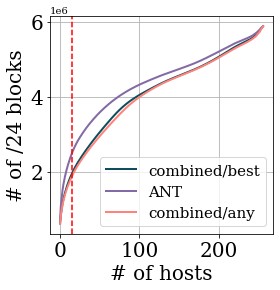

In [94]:
fig, ax = plt.subplots(figsize=(4,4))
ax = plot_cdf(mergedsurvey_filtered_df, 'merged', ax, COLORS[0])
ax = plot_cdf(mergedsurvey_filtered_df, 'ant', ax, COLORS[1])
ax = plot_cdf(merged_any_ant_blk_df, 'merged', ax, COLORS[2])
ax.legend(['combined/best', 'ANT', 'combined/any'], fontsize=15)
ax.set_xlabel('# of hosts', fontsize=20)
ax.set_ylabel('# of /24 blocks', fontsize=20)
plt.axvline(x=15, c='r', ls='--')
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
plt.savefig('figs_pam/sparse_survey_91.png', bbox_inches='tight')
plt.savefig('figs_pam/sparse_survey_91.pdf', bbox_inches='tight')


In [299]:
def asn_dask(x):    
    
    #print(x)
    asninfo = meta.lookup(x)
    #print(asninfo)
    if len(asninfo) == 1:
        return ','.join([str(asn) for asn in asninfo[0]['asns']])
    elif len(asninfo) == 0:
        return ''
    else:
        return ','.join([asninfo[i]['asns'] for i in range(len(asninfo))])

In [23]:
merged_any_ant_blk_df['/24_str'] = merged_any_ant_blk_df['/24'].apply(lambda x: int2ip24(x))

merged_any_ant_blk_df['asn'] = merged_any_ant_blk_df['/24_str'].astype(str).apply(lambda x:asn_dask(x))

In [25]:
mergedsurvey_filtered_df['/24_str'] = mergedsurvey_filtered_df['/24'].apply(lambda x: int2ip24(x))

mergedsurvey_filtered_df['asn'] = mergedsurvey_filtered_df['/24_str'].astype(str).apply(lambda x:asn_dask(x))

In [28]:
ant_survey91_df['/24_str'] = ant_survey91_df['/24'].apply(lambda x: int2ip24(x))

ant_survey91_df['asn'] = ant_survey91_df['/24_str'].astype(str).apply(lambda x:asn_dask(x))

In [83]:
ant_sparse_blks = [ant_survey91_df['survey_91']<15]['/24'].tolist()

In [ ]:
#ANT non sparse blocks within an AS
ant_survey91_asn_df = ant_survey91_df.groupby('asn')['/24'].count().reset_index()
ant_survey91_nonsparse_asn_df = ant_survey91_df[ant_survey91_df['survey_91']>=15].groupby('asn')['/24'].count().reset_index()

In [216]:
# ANT calculate fraction of non sparse blocks per AS
ant_asn_df = ant_survey91_asn_df.merge(ant_survey91_nonsparse_asn_df, on='asn', how='left').fillna(0)
ant_asn_df.rename(columns={'/24_x':'/24_all', '/24_y':'/24_nonsparse'}, inplace=True)
ant_asn_df['frac_nonsparse'] = ant_asn_df['/24_nonsparse'] / ant_asn_df['/24_all']

In [30]:
censys_ddf['/24'] = censys_ddf.map_partitions(get_24_from_int)

In [33]:
# Fraction of non sparse blocks in ANT + Censys-best per AS
mergedsurvey_asn_df = mergedsurvey_filtered_df.groupby('asn')['/24'].count().reset_index()
mergedsurvey_nonsparse_asn_df = mergedsurvey_filtered_df[mergedsurvey_filtered_df['combined_survey_91']>=15].groupby('asn')['/24'].count().reset_index()
mergedsurvey_asn_df = mergedsurvey_asn_df.merge(mergedsurvey_nonsparse_asn_df, on='asn', how='left').fillna(0)
mergedsurvey_asn_df.rename(columns={'/24_x':'/24_all', '/24_y':'/24_nonsparse'}, inplace=True)
mergedsurvey_asn_df['frac_nonsparse'] = mergedsurvey_asn_df['/24_nonsparse'] / mergedsurvey_asn_df['/24_all']

In [300]:
merged_survey91_df['/24_str'] = merged_survey91_df['/24'].apply(lambda x: int2ip(x))
merged_survey91_df['asn'] = merged_survey91_df['/24_str'].apply(lambda x: asn_dask(x))


In [117]:
merged_any_asn_df = merged_any_ant_blk_df.groupby('asn')['/24'].count().reset_index()
merged_any_nonsparse_asn_df = merged_any_ant_blk_df[merged_any_ant_blk_df['merged']>=15].groupby('asn')['/24'].count().reset_index()
merged_any_asn_df = merged_any_asn_df.merge(merged_any_nonsparse_asn_df, on='asn', how='left').fillna(0)
merged_any_asn_df.rename(columns={'/24_x':'/24_all', '/24_y':'/24_nonsparse'}, inplace=True)
merged_any_asn_df['frac_nonsparse'] = merged_any_asn_df['/24_nonsparse'] / merged_any_asn_df['/24_all']

In [146]:
def plot_asn_cdf(df, color, ax):
    cdf_df = df[df['asn']!=''].groupby(['frac_nonsparse'])['asn'].count().reset_index()
    cdf_df['cumsum'] = cdf_df['asn'].cumsum()
    cdf_df['cumfrac'] = cdf_df['cumsum'] / cdf_df['cumsum'].max()
    cdf_df['cumsum_k'] = cdf_df['cumsum'] / 1000
    
    cdf_df.plot.line(x='frac_nonsparse', y='cumsum_k', ax=ax, color=color, lw=2, grid=True)
    return ax

[10. 20. 30. 40. 50. 60. 70. 80.] [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


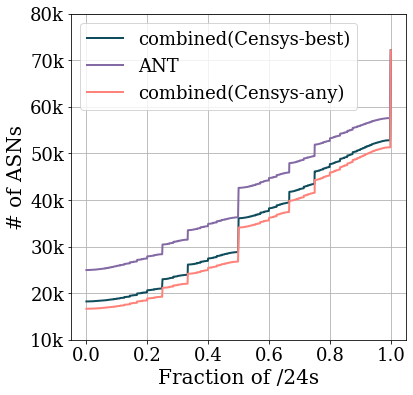

In [178]:
fig, ax = plt.subplots(figsize=(6,6))
ax = plot_asn_cdf(mergedsurvey_asn_df, COLORS[0], ax)
ax = plot_asn_cdf(ant_asn_df, COLORS[1], ax)
ax = plot_asn_cdf(merged_any_asn_df,  COLORS[2], ax)
ax.legend(['combined(Censys-best)', 'ANT', 'combined(Censys-any)'], fontsize=18)
ax.set_xlabel('Fraction of /24s', fontsize=20)
ax.set_ylabel('# of ASNs', fontsize=20)
#plt.axvline(x=15, c='r', ls='--')
a=ax.get_xticks().tolist()
labels, locations = plt.yticks()
print(labels, locations)
plt.yticks(labels, ['10k', '20k', '30k', '40k', '50k', '60k', '70k', '80k'])
#plt.yticks([0,1,2,3,4,5, 6], ['20k', '30k', '40k', '50k', '60k', '70k', '80k'],rotation=0) 
ax.tick_params(axis='both', which='major', labelsize=18, rotation=0)
#plt.savefig('figs_pam/sparse_survey_91.png', bbox_inches='tight')
plt.savefig('figs_pam/sparse_survey_91.pdf', bbox_inches='tight')


In [47]:
#load censys-any
files = get_files_no_pfx('/data1/manasvini/censys_address_history_new/')
censys_any_ddf = dd.read_parquet(files, blocksize='20MB').repartition(partition_size='10MB')

In [48]:
censys_cols = ['censys_survey_'+ str(i) for i in range(91,92)]
blks_ip_censys_ct_df = censys_any_ddf.groupby('/24')['censys_survey_91'].sum().compute().reset_index()

censys_blk_recent_df = blks_ip_censys_ct_df[['/24', 'censys_survey_91']]
censys_blk_recent_df['/24_str'] = censys_blk_recent_df['/24'].apply(lambda x:int2ip(x))

In [106]:
ant_survey91_df['/24_str']  = ant_survey91_df['/24'].apply(lambda x:int2ip(x))

In [49]:
# Censys-any get non sparse blocks in an AS
censys_blk_recent_df['asn'] =  censys_blk_recent_df['/24_str'].astype(str).apply(lambda x:asn_dask(x))
censys_sparse_as_df = censys_blk_recent_df[(censys_blk_recent_df['censys_survey_91']>=15)&(~censys_blk_recent_df['/24_str'].isin(ant_survey91_df['/24_str'].tolist()))].groupby('asn')['/24_str'].count().reset_index()
censys_total_as_df = censys_blk_recent_df[~censys_blk_recent_df['/24_str'].isin(ant_survey91_df['/24_str'].tolist())].groupby('asn')['/24_str'].count().reset_index()
censys_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
censys_sparse_as_df = censys_sparse_as_df.merge(censys_total_as_df, on='asn', how='inner')



In [50]:
censys_best_blk_df = censys_ddf.groupby('/24')['survey_91'].sum().compute().reset_index()
censys_best_blk_df['/24_str'] = censys_best_blk_df['/24'].apply(lambda x:int2ip(x))

censys_best_blk_df['asn'] =  censys_best_blk_df['/24_str'].astype(str).apply(lambda x:asn_dask(x))

In [51]:
censys_best_sparse_as_df = censys_best_blk_df[(censys_best_blk_df['survey_91']>=15)&(~censys_best_blk_df['/24_str'].isin(ant_survey91_df['/24_str'].tolist()))].groupby('asn')['/24_str'].count().reset_index()
censys_best_total_as_df = censys_best_blk_df[~censys_best_blk_df['/24_str'].isin(ant_survey91_df['/24_str'].tolist())].groupby('asn')['/24_str'].count().reset_index()
censys_best_sparse_as_df.rename(columns={'/24_str':'sparse_/24_str'}, inplace=True)
censys_best_sparse_as_df = censys_best_sparse_as_df.merge(censys_best_total_as_df, on='asn', how='inner')

In [191]:
censys_best_asns_df = censys_best_sparse_as_df[censys_best_sparse_as_df['asn']!='']
censys_best_asns_df['ASN'] = 'AS' + censys_best_asns_df['asn']

/home/msethuraman3/censys-ant/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [203]:
mergedsurvey_asn_df_filtered = mergedsurvey_asn_df[(~mergedsurvey_asn_df['asn'].str.contains(','))&(mergedsurvey_asn_df['asn']!='')]
mergedsurvey_asn_df_filtered['asn'] = mergedsurvey_asn_df_filtered['asn'].astype(int)

In [217]:
ant_asn_df_filtered = ant_asn_df[(~ant_asn_df['asn'].str.contains(','))&(ant_asn_df['asn']!='')]
ant_asn_df_filtered['asn'] = ant_asn_df_filtered['asn'].astype(int)

In [302]:
merged_survey91_df = merged_survey91_df[(~merged_survey91_df['asn'].str.contains(','))&(merged_survey91_df['asn']!='')]

In [308]:
merged_survey91_asn_df = merged_survey91_df[merged_survey91_df['combined_survey_91']>=15].groupby(['asn'])['/24'].count().reset_index()

In [314]:
#ant_survey91_df['/24_str'] = ant_survey91_df['/24'].apply(lambda x:int2ip(x))
ant_survey91_df['asn'] = ant_survey91_df['/24_str'].apply(lambda x: asn_dask(x))
ant_survey91_df = ant_survey91_df[ant_survey91_df['survey_91']>=15].groupby(['asn'])['/24'].count().reset_index()

In [142]:

censys_sparse_as_df['censys_sparse_perc'] = (100 * censys_sparse_as_df['sparse_/24_str'] / censys_sparse_as_df['/24_str']).astype(int)
censys_sparse_ct_df = censys_sparse_as_df.groupby('censys_sparse_perc')[['asn']].count().reset_index()
censys_sparse_ct_df['cumsum'] = censys_sparse_ct_df['asn'].cumsum()
censys_sparse_ct_df['cumfrac'] = censys_sparse_ct_df['cumsum'] /censys_sparse_ct_df['cumsum'].max()

censys_best_sparse_as_df['censys_sparse_perc'] = (100 * censys_best_sparse_as_df['sparse_/24_str'] / censys_best_sparse_as_df['/24_str']).astype(int)
censys_best_sparse_ct_df = censys_best_sparse_as_df.groupby('censys_sparse_perc')[['asn']].count().reset_index()
censys_best_sparse_ct_df['cumsum'] = censys_best_sparse_ct_df['asn'].cumsum()
censys_best_sparse_ct_df['cumfrac'] = censys_best_sparse_ct_df['cumsum'] /censys_best_sparse_ct_df['cumsum'].max()

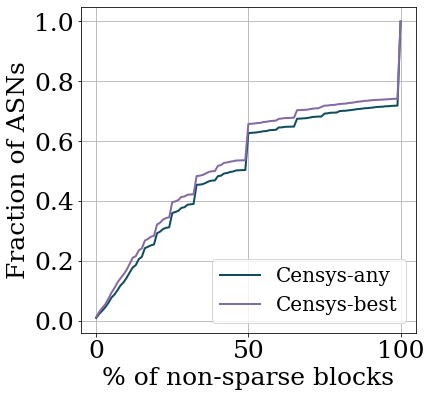

In [148]:
fig, ax = plt.subplots(figsize=(6,6))
ax = censys_sparse_ct_df.plot(x='censys_sparse_perc', y='cumfrac', ax =ax, lw=2, c=COLORS[0], grid=True)
ax = censys_best_sparse_ct_df.plot(x='censys_sparse_perc', y='cumfrac', ax =ax, lw=2, c=COLORS[1], grid=True)

ax.legend(['Censys-any', 'Censys-best'], fontsize=20, loc='lower right')

ax.set_ylabel('Fraction of ASNs', fontsize=25)
ax.set_xlabel('% of non-sparse blocks', fontsize=25)
#ax.set_ylim([10, 1e5])
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
plt.savefig('figs_pam/censys_blocks_non_sparse_new.pdf', bbox_inches='tight')

In [ ]:
## Number of protocol probes per /24 block

In [7]:
proto_ct_all_ddf = dd.read_parquet('/data1/manasvini/censys/proto/best_proto', block_size='10MB')

In [9]:
proto_ct_all_ddf['/24'] = proto_ct_all_ddf.map_partitions(get_24_from_int)

In [10]:
proto_24_df = proto_ct_all_ddf.groupby(['/24', 'best_proto'])['ipint'].count().compute().reset_index()

In [17]:
best_proto_ct_df = proto_24_df.groupby('/24')['best_proto'].count().reset_index()

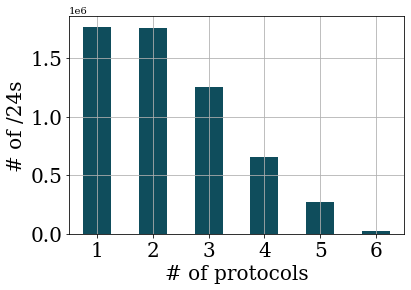

In [73]:
fig, ax = plt.subplots(figsize=(6,4))
best_proto_ct_df.groupby('best_proto').count().plot.bar(ax=ax, grid=True, legend=False, color=COLORS[0])
ax.set_xlabel('# of protocols', fontsize=20)
ax.set_ylabel('# of /24s', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
plt.savefig('figs_pam/censys_proto_24.pdf', bbox_inches='tight')
plt.savefig('figs_pam/censys_proto_24.png', bbox_inches='tight')


In [75]:
proto_24_df['/24_str'] = proto_24_df['/24'].apply(lambda x: int2ip24(x))
proto_24_df['asn'] = proto_24_df['/24_str'].astype(str).apply(lambda x:asn_dask(x))

In [82]:
single_proto_ases = as_proto_df[as_proto_df['best_proto']==1]['asn'].tolist()

In [76]:
as_proto_df = proto_24_df.groupby('asn')['best_proto'].nunique().reset_index()
asn_cdf = as_proto_df[as_proto_df['asn']!=''].groupby('best_proto')['asn'].count().reset_index()

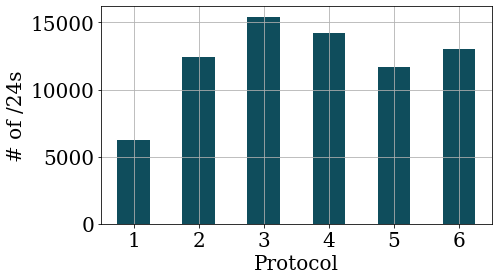

In [77]:

fig, ax = plt.subplots(figsize=(7,4))
asn_cdf.plot.bar(x='best_proto', y='asn', ax=ax, color=COLORS[0], grid=True, legend=False)
ax.set_xlabel('Protocol', fontsize=20)
ax.set_ylabel('# of /24s', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
plt.savefig('figs_pam/censys_proto_asn.pdf', bbox_inches='tight')
plt.savefig('figs_pam/censys_proto_asn.png', bbox_inches='tight')